# Clustering

In [ ]:
import os

if "visualization" in os.getcwd():
    os.chdir("..")

if "notebooks" in os.getcwd():
    os.chdir("..")
os.getcwd()

In [2]:
from src.dataset import register_default_datasets, DEFAULT_CLASS_NAMES

import numpy as np
import copy
import matplotlib.pyplot as plt
import tqdm

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import detection_utils as utils
from detectron2.structures import polygons_to_bitmask

import torchvision.models as models
from torchvision import transforms as T
import torch
from PIL import Image

register_default_datasets()

In [3]:
def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    data = dict()

    data["height"]  = dataset_dict["height"]
    data["width"]  = dataset_dict["width"]
    data["file_name"] = dataset_dict["file_name"]
    data["image"] = image

    instances = utils.annotations_to_instances(dataset_dict["annotations"], image.shape[:2])
    data["instances"] = utils.filter_empty_instances(instances)
    
    return data

In [4]:
dataset =  DatasetCatalog.get("train")
item = mapper(dataset[3])
image = item["image"]
instances = item["instances"]
boxes = instances.gt_boxes
masks_polygons = instances.gt_masks

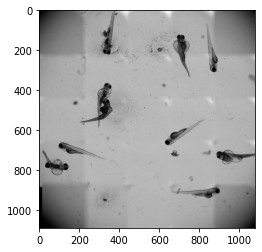

In [5]:
plt.imshow(image)
plt.show()

In [6]:
images = []

for item in tqdm.tqdm(dataset):
    item = mapper(item)
    image = item["image"]
    instances = item["instances"]
    boxes = instances.gt_boxes
    masks_polygons = instances.gt_masks
    for box, polygon in zip(boxes, masks_polygons):
        mask = polygons_to_bitmask(polygon, item["height"], item["width"])
        mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        x1,y1, x2, y2 = box.numpy().astype(np.int32)
        images.append(np.where(mask, image, 0)[y1:y2, x1:x2])
        #plt.imshow(images[-1])
        #plt.show()
images = np.array(images)

100%|██████████| 39/39 [00:11<00:00,  3.34it/s]


In [7]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [8]:
model = models.resnet34(pretrained=True)
model.fc = Identity()
model.eval()



normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = T.Compose([T.ToTensor(), normalize])

In [9]:
outputs = []
for img in tqdm.tqdm(images):
    #img = Image.fromarray(img)
    inputs =  transform(img)
    inputs = torch.unsqueeze(inputs, axis=0)

    outputs.append(model(inputs))

100%|██████████| 452/452 [00:19<00:00, 22.61it/s]


In [10]:
features = torch.cat(outputs).cpu().detach().numpy()

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
features_2d.shape

(452, 2)

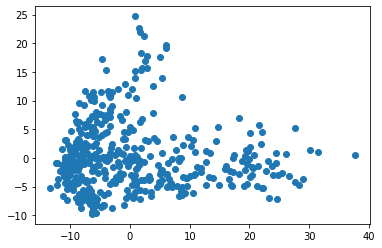

In [12]:
plt.scatter(features_2d[:, 0], features_2d[:, 1])
plt.show()

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(features)

In [14]:
kmeans.labels_.shape

(452,)

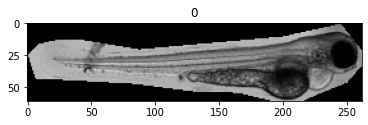

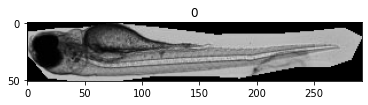

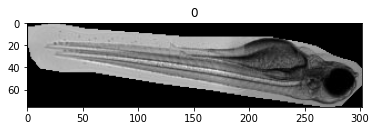

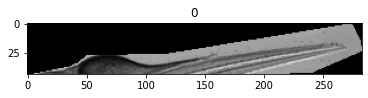

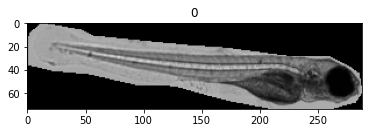

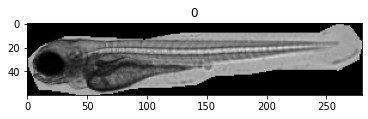

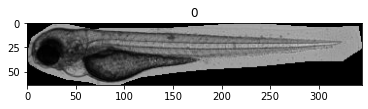

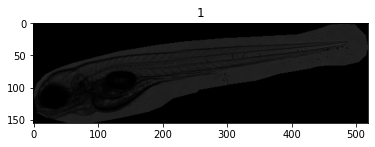

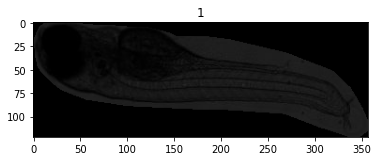

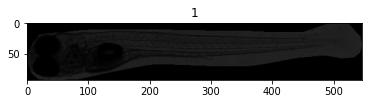

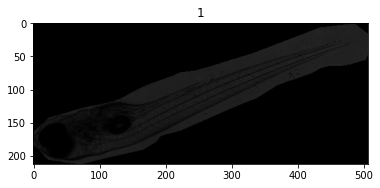

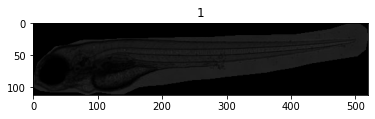

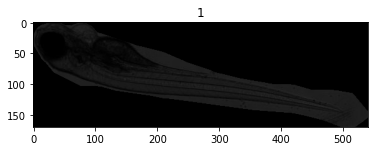

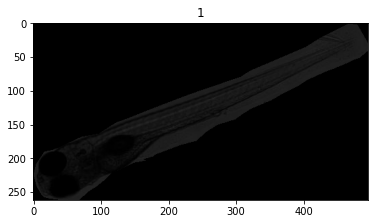

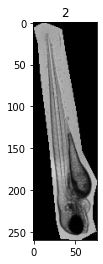

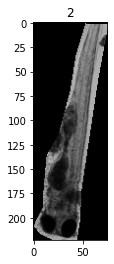

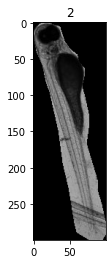

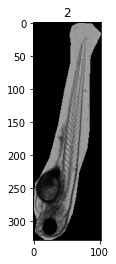

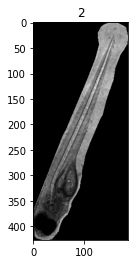

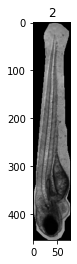

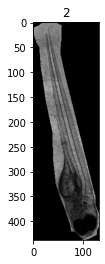

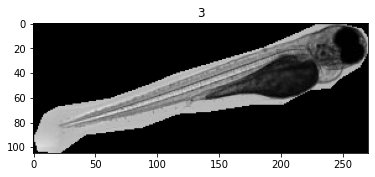

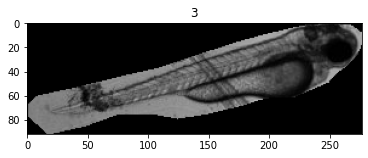

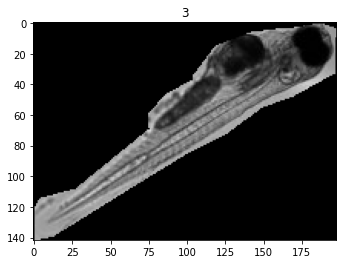

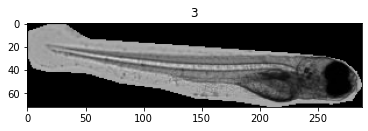

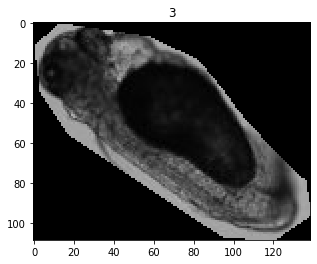

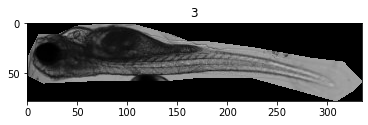

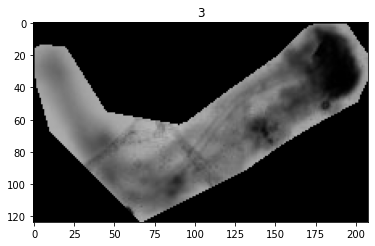

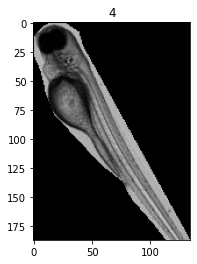

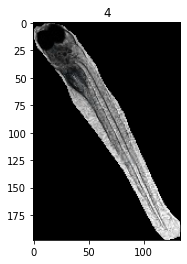

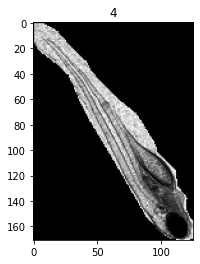

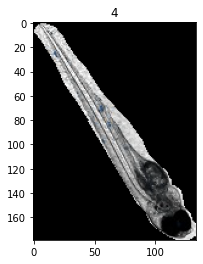

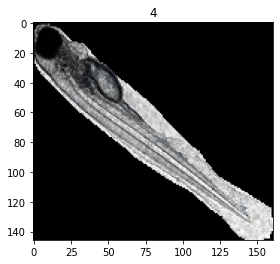

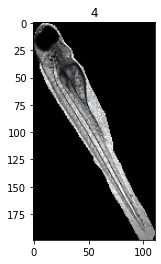

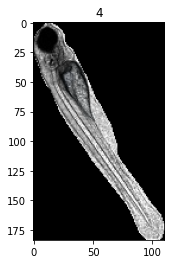

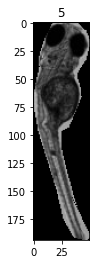

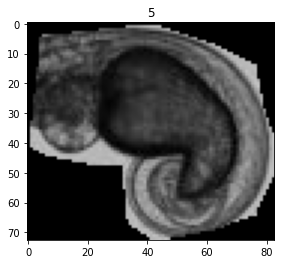

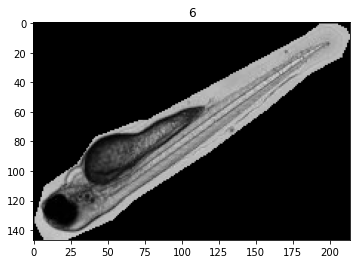

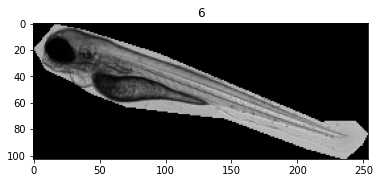

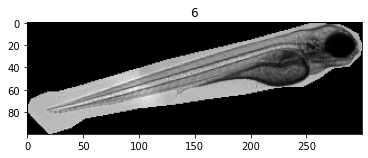

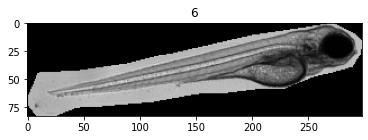

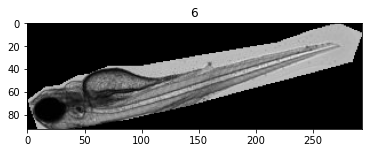

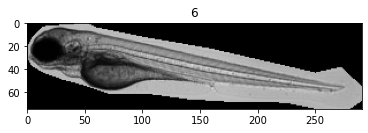

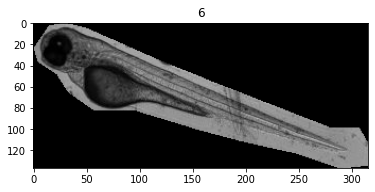

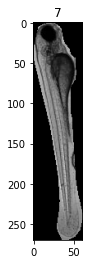

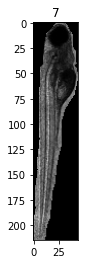

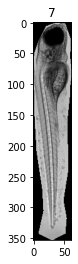

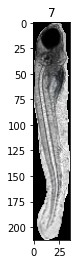

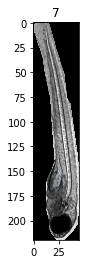

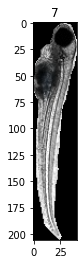

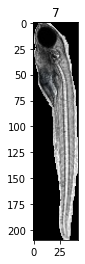

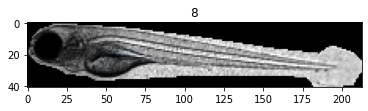

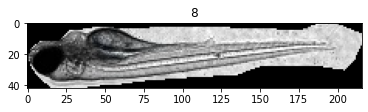

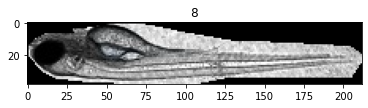

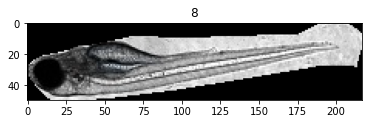

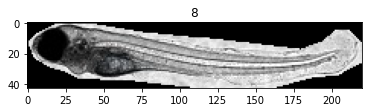

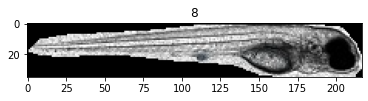

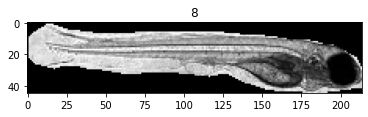

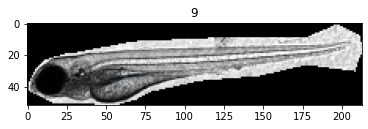

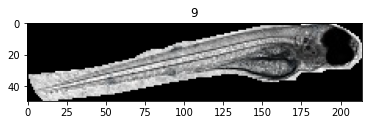

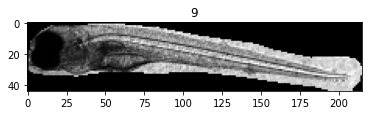

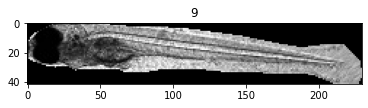

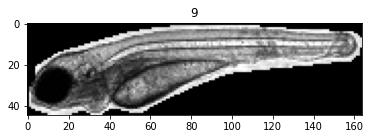

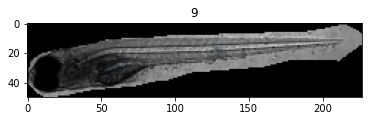

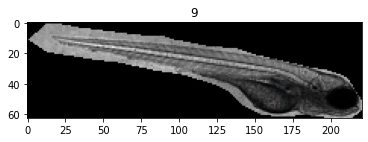

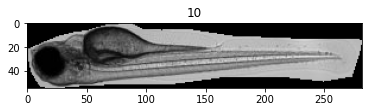

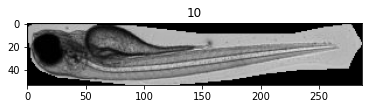

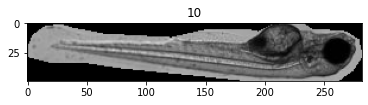

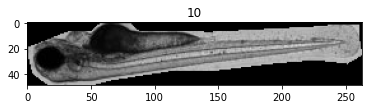

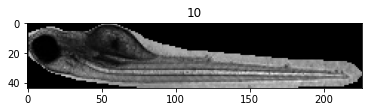

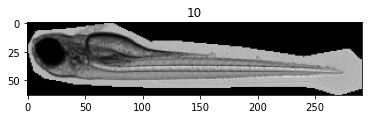

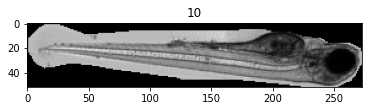

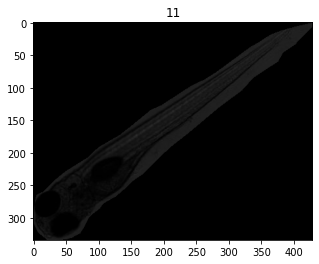

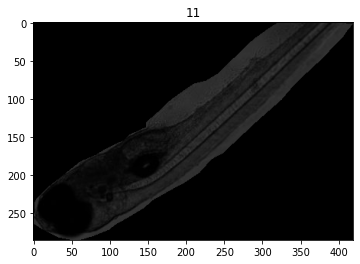

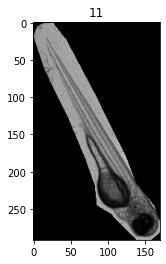

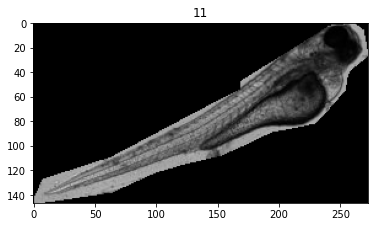

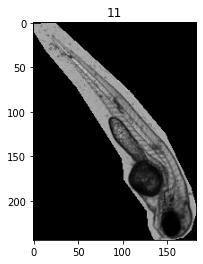

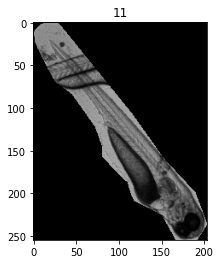

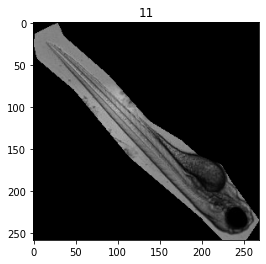

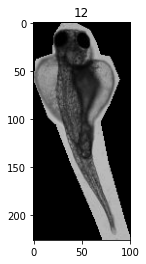

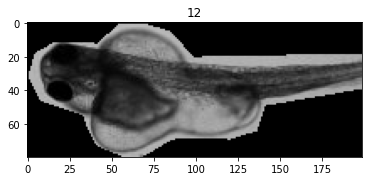

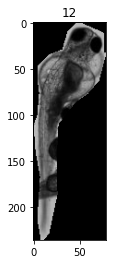

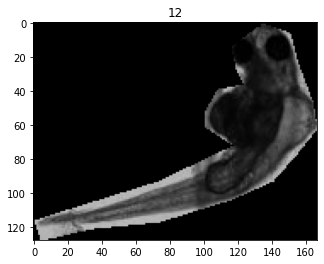

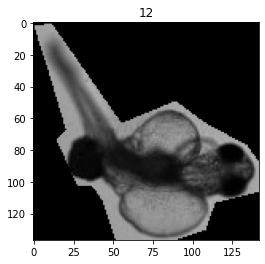

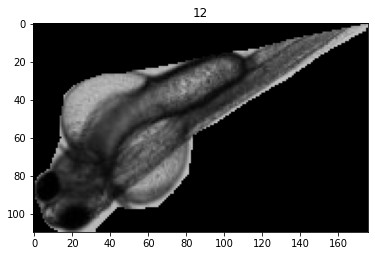

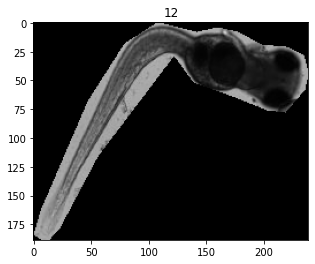

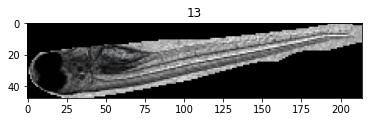

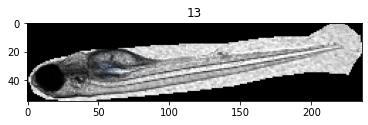

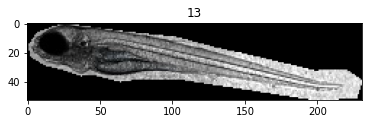

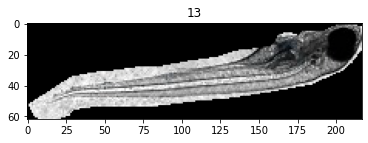

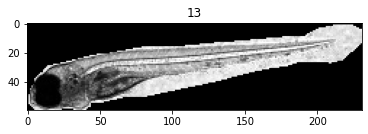

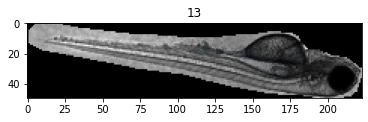

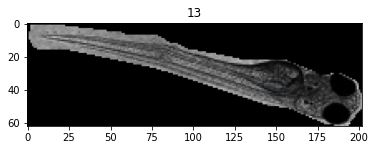

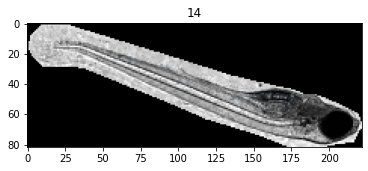

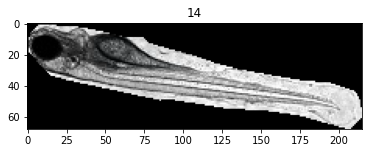

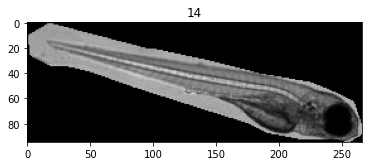

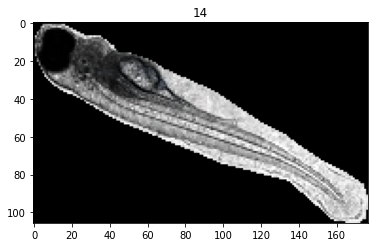

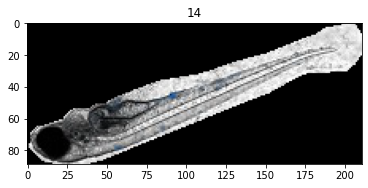

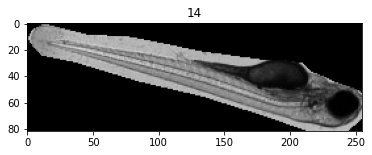

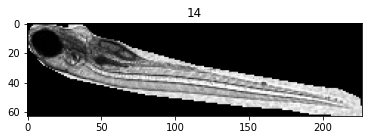

In [15]:
label = 15
for label in np.unique(kmeans.labels_):
    for i, img in enumerate(images[kmeans.labels_ == label]):
        plt.imshow(img)
        plt.title(str(label))
        plt.show()

        if i > 5:
            break